# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [47]:
# Defines
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)
batch_size = 128
learning_rate = 0.001
epochs = 40

cuda


In [11]:
# Define transforms
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create training set and define training dataloader
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

truck


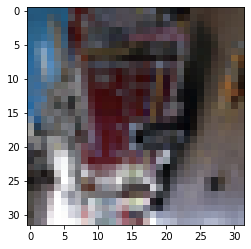

car


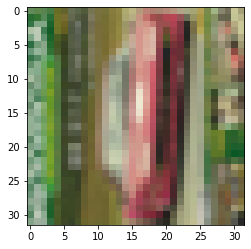

ship


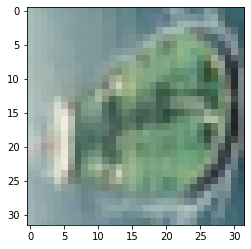

cat


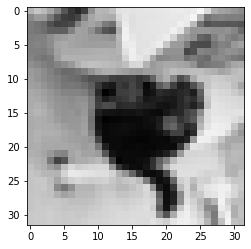

ship


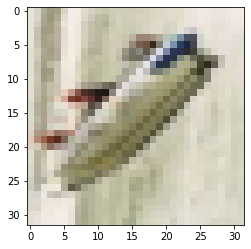

In [7]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

#### Network Architecture:

As we are developing a network for image classifications, convolutional layer will provide more optimized and effiecent filters for the input 3-channel (32x32) images.

P.S: The following values was tuned based on trials and errors 

*__First Convolutional Layer:__* 

* 3-channel means that we have 3 inputs to the layer.
* output is chosen to be 32 relative big number to hold most of the images pixels info.
* kernel is choosed to be 3 (5 and 7 was also tried but it was found that 3 is the best one).

*__Second and fourth layers:__* 

* just max pool layers with (2x2) filter

*__Second Convolutional Layer (forth layer):__*

* with 32 input from the previous convolutional and output to be 64, again to maintain much info about the image.
* kernal set to be also (3x3) filter

The rest three layers are normal linear layers with inputs and output choosed to roughly be in the mean between each layer.

*__First Linear Layer:__* 

As we choosed 2 convolutional layers and 2 pool layers before this one, the dimension of the layer input should be calculated based on the following formulas:

$$
convolutional output Width = (inputWidth - kernel Width + 2Padding)/stride + 1
$$
$$
pool output Width = flooring(inputWidth/kernelWidth)
$$

therefore,
* *The output width of the first conv layer is: (32-3+2(0))/1 + 1 = 30
* *The output width of the first pool layer is ceil(30/2) = 15
* *The output width of the second conv layer is: (15-3+2(0))/1 + 1 = 13 
* *The output width of the second pool layer is ceil(15/2) = 6
* *Finally the final size of the second pool layer is a tensor [64, 6, 6] which need to be flattened into 1-D tensor before use.


In [32]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # CIFAR10 has image of 3 color channels and size 32*32
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [52]:
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [53]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)


start.record()

train_losses = []
for e in range(epochs):
    tot_train_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader, 0):
        images=images.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if (batch_idx % 250) == 249:
            train_loss = tot_train_loss/250
            print("Loss each batch: {:.3f}.. ".format(train_loss))
            tot_train_loss = 0
            train_losses.append(train_loss)

end.record()

torch.cuda.synchronize()

print("Total training time: {:.3f}..".format(start.elapsed_time(end)))

Loss each batch: 1.516.. 
Loss each batch: 0.998.. 
Loss each batch: 0.800.. 
Loss each batch: 0.617.. 
Loss each batch: 0.444.. 
Loss each batch: 0.288.. 
Loss each batch: 0.171.. 
Loss each batch: 0.103.. 
Loss each batch: 0.084.. 
Loss each batch: 0.079.. 
Loss each batch: 0.051.. 
Loss each batch: 0.055.. 
Loss each batch: 0.057.. 
Loss each batch: 0.042.. 
Loss each batch: 0.042.. 
Loss each batch: 0.050.. 
Loss each batch: 0.038.. 
Loss each batch: 0.037.. 
Loss each batch: 0.034.. 
Loss each batch: 0.029.. 
Loss each batch: 0.043.. 
Loss each batch: 0.024.. 
Loss each batch: 0.029.. 
Loss each batch: 0.029.. 
Loss each batch: 0.033.. 
Loss each batch: 0.041.. 
Loss each batch: 0.022.. 
Loss each batch: 0.018.. 
Loss each batch: 0.040.. 
Loss each batch: 0.020.. 
Loss each batch: 0.035.. 
Loss each batch: 0.018.. 
Loss each batch: 0.016.. 
Loss each batch: 0.027.. 
Loss each batch: 0.023.. 
Loss each batch: 0.021.. 
Loss each batch: 0.027.. 
Loss each batch: 0.017.. 
Loss each ba

Plot the training loss (and validation loss/accuracy, if recorded).

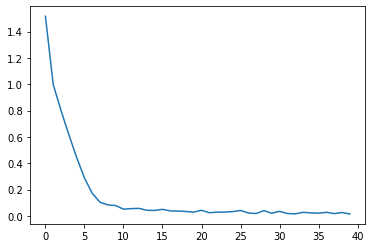

In [54]:
%matplotlib inline
plt.plot(train_losses, label='Training loss')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [55]:
test_correct = 0

dataiter = iter(train_loader)
images, labels = dataiter.next()

for batch_idx, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)

    log_ps = model(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(top_class.shape)
    test_correct += equals.sum().item()

print("Test Accuracy: {:.3f}".format(test_correct/len(test_loader.dataset)))

Test Accuracy: 0.722


## Saving your model
Using `torch.save`, save your model for future loading.

In [56]:
torch.save(model, 'imageClassifier_checkpoint.pth')

In [57]:
model_loaded = torch.load('imageClassifier_checkpoint.pth')

In [58]:
print("Our model: \n\n", model, '\n')
print("Our loaded model: \n\n", model_loaded, '\n')

Our model: 

 Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
) 

Our loaded model: 

 Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
) 



In [59]:
test_correct = 0

dataiter = iter(train_loader)
images, labels = dataiter.next()

for batch_idx, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)

    # using the new model:
    log_ps = model_loaded(images)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(top_class.shape)
    test_correct += equals.sum().item()

print("Test Accuracy: {:.3f}".format(test_correct/len(test_loader.dataset)))

Test Accuracy: 0.722


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The in house built module achieved an accuracy of 72.2% with very simple architecture as discribed earlier in this notebook, with only 2 conv2d layers, 2 MaxPool layers and 3 Linear layers, it took about 5.7 minutes on 1536 CUDA cores GPU to train the network using 40 epochs.

Recalling the train loss plot again in the following cell, we see that we can expect to achieve very close results with about only 12 epochs as the loss seems to decrease alot only after the first 10 epochs.

I recommend to use our in house built module for the following reasons:

1. It already satisfy our Accuracy target which is (>70%).
2. The module training time is reasonable.
3. Based on new data and requirements in the future, we will have the freedom to re-tune or customize our solution to fit our new needs, rather than buying again a new network model.
4. We can always 



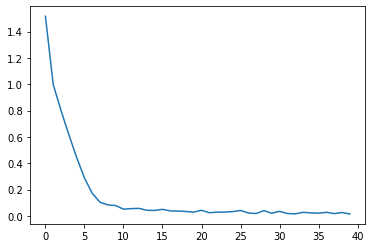

In [54]:
%matplotlib inline
plt.plot(train_losses, label='Training loss')